In [ ]:
import os
os.environ.pop("http_proxy", None)
os.environ.pop("https_proxy", None)
os.environ["NO_PROXY"] = "localhost,127.0.0.1"

from config import Config
from unimemrag.embedding.models.ClipEmbedding import ClipEmbedding
from unimemrag.vector_store.qdrant import QdrantStore

cfg = Config(
      model_name="../ckpts/clip-vit-base-patch32",
      collection="mmrag_bench",
      batch_size=500,
)
embedding_model = ClipEmbedding(model_name=cfg.model_name)
vector_store = QdrantStore(cfg, embedding_model.dim)

In [ ]:
# vector_store.clear_collection()

In [ ]:
from pathlib import Path
from itertools import islice
from unimemrag.retriever.retriever import Retriever

image_paths = sorted(Path("benchmark/mrag-bench/image_corpus").glob("*"))
result = vector_store.ingest_images(
    embedding_model,
    image_paths,
    caption_builder=None,
    show_progress=True,
)
print(result["images_indexed"], "images indexed")
print(result["failures"])

In [ ]:
retriever = Retriever(embedding_model, vector_store, top_k=cfg.top_k)

results = retriever.search_by_text(query="A photo of an bmw car")


from unimemrag.retriever import as_image_node, show
image_nodes = [as_image_node(node) for node in results if node.payload and node.payload.get("modality") == "image"]
print(results)
for node in image_nodes:
      show(node, base_dir=Path("benchmark/mrag-bench"))

In [1]:
# load from disk
import sys
sys.path.append('..')

import os
os.environ.pop("http_proxy", None)
os.environ.pop("https_proxy", None)
os.environ["NO_PROXY"] = "localhost,127.0.0.1"

from config import Config
from unimemrag.embedding.models.ClipEmbedding import ClipEmbedding
from unimemrag.vector_store.qdrant import QdrantStore
from unimemrag.retriever.retriever import Retriever

cfg = Config(collection="mmrag_bench", prefer_grpc=False)
embedder = ClipEmbedding(cfg.model_name)
store = QdrantStore(cfg, vector_size=embedder.dim) 
retriever = Retriever(embedder, store, top_k=cfg.top_k)

/hpc2hdd/home/sguo349/miniconda3/envs/unimemrag/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/hpc2hdd/home/sguo349/miniconda3/envs/unimemrag/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/hpc2hdd/home/sguo349/junjiejiang/algorithm/UniMemRAG/examples/../unimemrag/vector_store/qdrant.py:40: UserWarning: Qdrant client version 1.15.1 is incompatib

In [ ]:
results = retriever.search_by_text(query="What is not likely to happen when strawberry goes bad?")

In [2]:
from unimemrag.vlm.QwenVL import QwenVL

vlm = QwenVL(
      model_path="../../ckpts/Qwen2.5-VL-7B-Instruct",
      torch_dtype="auto",
      device_map="auto",
      attn_implementation="flash_attention_2",
      # min_pixels=256*28*28, max_pixels=1280*28*28,  # 如需控制视觉Token范围可解开
)

`torch_dtype` is deprecated! Use `dtype` instead!
You are attempting to use Flash Attention 2 without specifying a torch dtype. This might lead to unexpected behaviour
Loading checkpoint shards: 100%|██████████| 5/5 [00:19<00:00,  3.81s/it]
The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


In [ ]:
from pathlib import Path

answer, nodes = retriever.answer_with_vlm(
    query="What is not likely to happen when strawberry goes bad?",
    vlm=vlm,
    target_modality="image",   # 只取图像向量
    top_k=3,
    base_dir=Path("benchmark/mrag-bench"),  # 解析相对路径
    gen_kwargs={"max_new_tokens": 4096}
)
print(answer)

In [ ]:
for node in nodes:
    show(node, base_dir=Path("benchmark/mrag-bench"))

In [3]:
from datasets import load_dataset
import os
os.environ.pop("http_proxy", None)
os.environ.pop("https_proxy", None)
os.environ["NO_PROXY"] = "localhost,127.0.0.1"


benchmark = load_dataset("uclanlp/MRAG-Bench", split="test")

In [4]:
benchmark[0]

{'id': '0',
 'aspect': 'Perspective',
 'scenario': 'Scope',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500>,
 'gt_images': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x455>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>],
 'question': 'Can you identify this animal?',
 'A': 'silky_terrier',
 'B': 'Yorkshire_terrier',
 'C': 'Australian_terrier',
 'D': 'Cairn_terrier',
 'answer_choice': 'A',
 'answer': 'silky_terrier',
 'image_type': 'Animal',
 'source': 'Imagenet',
 'retrieved_images': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=R

In [5]:
from evaluate_mrag_bench import *

datasets = benchmark
results, accuracy = evaluate(retriever, vlm, datasets, base_dir=Path("benchmark/mrag-bench"), top_k=5, use_image_query=True)

2025-10-21 12:50:24 | INFO     | evaluate_mrag_bench:evaluate:333 - Accuracy: 


In [6]:
accuracy

0.5772357723577236

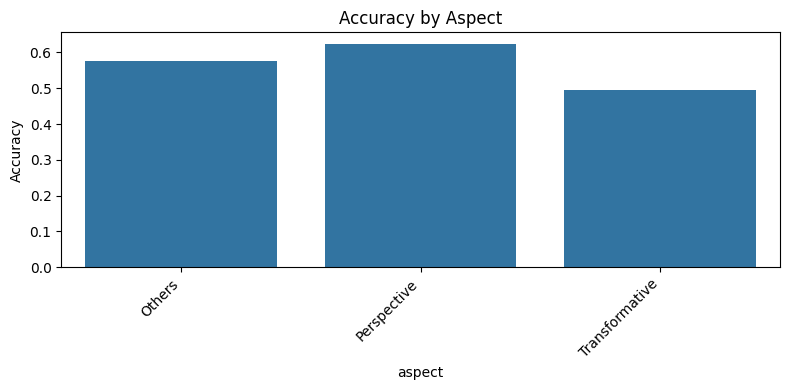

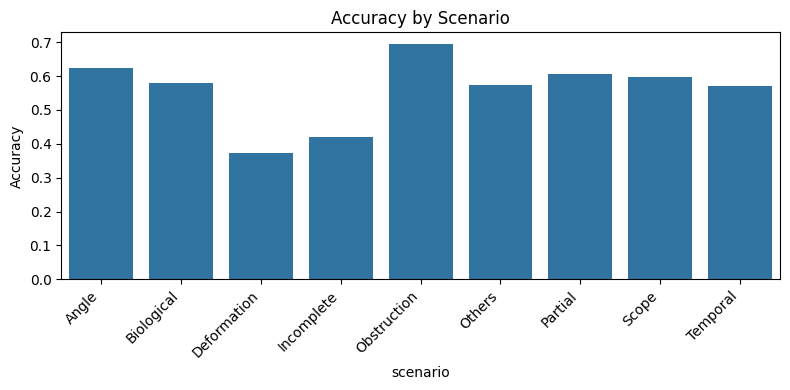

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

df = pd.read_json(Path("results/mrag_bench_results.jsonl"), lines=True)
df["correct"] = df["model_choice"] == df["gt_choice"]

aspect_acc = df.groupby("aspect")["correct"].mean().reset_index()
scenario_acc = df.groupby("scenario")["correct"].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(data=aspect_acc, x="aspect", y="correct")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.title("Accuracy by Aspect")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(data=scenario_acc, x="scenario", y="correct")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.title("Accuracy by Scenario")
plt.tight_layout()
plt.show()

In [10]:
[dataset for dataset in benchmark if dataset["scenario"] == "Deformation"][:5]

[{'id': '3',
  'aspect': 'Transformative',
  'scenario': 'Deformation',
  'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1293x987>,
  'gt_images': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768>,
   <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1600x1067>,
   <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2000x1333>,
   <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x797>,
   <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768>],
  'question': 'Can you tell me the typical engine type for this car model and the cylinder liter size?',
  'A': '2.0L turbocharged inline-4',
  'B': '3.0L V6',
  'C': '2.5L inline-5',
  'D': '1.8L turbocharged inline-4',
  'answer_choice': 'A',
  'answer': '2.0L turbocharged inline-4',
  'image_type': 'Car',
  'source': 'Web',
  'retrieved_images': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x797>,
   <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=350x202>,
   <P